# Xgboost workshop (python version)
by Qi XU & Maxime KINET

# Competition: B2C - Predict conversion rates on breakdown services

For more detail see https://datascience-challenge.engie.com/#/challenge/28733

# Import Xgboost and other packages 

In [1]:
# install the package if you haven't do it before
#install.packages("xgboost", repos="http://cran.rstudio.com/")
#install.packages("Ckmeans.1d.dp",repos="http://cran.rstudio.com/")
library(xgboost)
library(Ckmeans.1d.dp)

# Now we need to load the train and test data sets

In [2]:
fold_ad = "C:/Users/IA2069/Documents/MK2016/"
train=read.csv(paste0(fold_ad,"train.CSV"))
goal = train$souscrit
head(train,n = 2) # head() shows the N first rows (default =6) of the data set (or DataFrame)

,DT_DEBT_ASSR,TYPE_OFFRE_GAZ,Tarif_ach,CODE_TYPE_COMPTAGE,PUIS_SOUS,PAYEUR_DIVERG,OFFRE,CAP_EC,CODE_STATUT_LOGEMENT,CODE_TYPE_HABITAT,...,LB_PROF_PAYR,souscrit,ass_fact,CRC,PARTENAIRES,MAILING,PAP,DARTY,TV,produit
1,2015-11-24,OM,T2,SIMP,6,0,DUAL,0,PRV,H1,...,SANS INCIDENT DE PAIEMENT,0,0,2,0,0,0,0,0,DEGEX+
2,2015-08-27,OM,T2,SIMP,6,0,DUAL,0,PRV,H1,...,RISQUE FAIBLE - CONFIANCE,0,0,0,0,0,0,0,2,DEGEX+


In [3]:
test=read.csv(paste0(fold_ad,"test.CSV"))
head(test,n=2)

,DT_DEBT_ASSR,TYPE_OFFRE_GAZ,Tarif_ach,CODE_TYPE_COMPTAGE,PUIS_SOUS,PAYEUR_DIVERG,OFFRE,CAP_EC,CODE_STATUT_LOGEMENT,CODE_TYPE_HABITAT,...,nb_contact_entrant,LB_PROF_PAYR,ass_fact,CRC,PARTENAIRES,MAILING,PAP,DARTY,TV,produit
1,2015-11-03,OM,T2,SIMP,6,0,DUAL,0,PRV,H1,...,6,SANS INCIDENT DE PAIEMENT,0,4,0,0,0,0,0,DEGEX+
2,2015-08-27,OM,T1,SIMP,6,0,DUAL,0,PRV,H2,...,0,SANS INCIDENT DE PAIEMENT,0,0,2,0,0,0,0,DEPEX+


# PRE PROCESSING 

In [4]:
test$souscrit <- NA # before merging the two sets we need to have the same number of columns
db <- rbind(train,test)#to join two dataframe vertically (=adding rows) we use rbind function
dim(db)

[1] 254945     42

In [5]:
# fill empty values
# replace by mean
db$AGE_TR_PRED_FMT[is.na(db$AGE_TR_PRED_FMT)] <- mean(db$AGE_TR_PRED_FMT,na.rm=T) 
db$REVENU_IRIS[is.na(db$REVENU_IRIS)]= mean(db$REVENU_IRIS,na.rm=T)
db$CAR_CHAR[is.na(db$CAR_CHAR)] =mean(db$CAR_CHAR,na.rm=T)
db$CODE_INSEE[is.na(db$CODE_INSEE)] =mean(db$CODE_INSEE,na.rm=T)
db$CRC[is.na(db$CRC)] =-mean(db$CRC,na.rm=T)
db$PARTENAIRES[is.na(db$PARTENAIRES)] =mean(db$PARTENAIRES,na.rm=T)
db$MAILING[is.na(db$MAILING)] =mean(db$MAILING,na.rm=T)
db$PAP[is.na(db$PAP)] =mean(db$PAP,na.rm=T)
db$DARTY[is.na(db$DARTY)]=mean(db$DARTY,na.rm=T)
db$TV[is.na(db$TV)]=mean(db$TV,na.rm=T)

# replace by single value
db$TYPIRIS_N1[db$TYPIRIS_N1=='']='Z'
db$PUIS_SOUS[is.na(db$PUIS_SOUS)] <- 0

In [6]:
# variables type lists
num_var_name = c('AGE_TR_PRED_FMT','CAP_EC','CAR_CHAR','CEL_FMT','CODE_INSEE','CRC','DARTY','FACT_LIGN_FMT', 
               'MAILING','MA_RLV_FMT','NB_COHABITANT','PAP', 'PARTENAIRES', 'PAYEUR_DIVERG','PREA', 'PUIS_SOUS', 'REVENU_IRIS',
               'TV', 'ass_fact','nb_cont_COUR_ENT', 'nb_cont_MAIL_ENT', 'nb_cont_RECLAMATION',
               'nb_cont_RECLAMATION_6M', 'nb_cont_TEL_ENT', 'nb_contact_entrant')
date_var_name  = c('DATE_ANC_CLI','DATE_EMMENAG','DT_DEBT_ASSR')
factor_var_name =  c('CODE_STATUT_LOGEMENT','CODE_STATUT_OCCUP','CODE_TYPE_COMPTAGE','CODE_TYPE_HABITAT','DRP','FREQ_FACT','LB_PROF_PAYR',
                    'OFFRE','SEG_VALEUR_N2_A','TYPE_OFFRE_GAZ','TYPIRIS_N1','Tarif_ach','produit')

In [7]:
# Transform of timestamps
db$DATE_ANC_CLI_year = floor(as.integer(as.Date('2017-01-01') -as.Date(db$DATE_ANC_CLI))/365)
db$DATE_EMMENAG_year = floor(as.integer(as.Date('2017-01-01') -as.Date(db$DATE_EMMENAG))/365)
date_timestamp = as.POSIXlt(db$DT_DEBT_ASSR)
db$DT_DEBT_ASSR_month = date_timestamp$mon
db$DT_DEBT_ASSR_week_day = date_timestamp$wday
db$DT_DEBT_ASSR_yday = as.integer( as.Date(db$DT_DEBT_ASSR)-as.Date('2015-01-01'))

In [8]:
# to save sometime all the factor data will not be used in this notebook
db_final = db[,c(num_var_name,c("DT_DEBT_ASSR_yday","DT_DEBT_ASSR_month","DT_DEBT_ASSR_week_day"))] 

In [9]:
# seperate train & test
train <- db_final[1:127472,]
test <- db_final[127473:254945,]

# Now we are ready for our Xgboost models

# Tunning

In [10]:
# define parameters we are going to use
params = list(                "objective" = "binary:logistic",
                              "eval_metric" = "auc",
                              "eta" = 0.5,
                              "max_depth" =  4,
                              "min_child_weight" = 10,
                              "subsample" = 0.9,
                              "colsample_bytree" = 0.9,
                              "nthread" = 3
                              )
num_trees = 5 # to save time you can test with more num_trees to get a better performance by yourself   

In [11]:
# training by build in cv function (random split)
xgb_cv = xgb.cv(param=params, data = as.matrix(train), label = goal, 
                nfold = 3, nrounds= num_trees)

[0]	train-auc:0.665743+0.023913	test-auc:0.657845+0.027283
[1]	train-auc:0.696028+0.023607	test-auc:0.686035+0.023313
[2]	train-auc:0.715902+0.014753	test-auc:0.710458+0.009973
[3]	train-auc:0.718558+0.017391	test-auc:0.711445+0.009693
[4]	train-auc:0.718996+0.018705	test-auc:0.712676+0.013812


In [12]:
# a voir pour la partie watchlist
bst = xgboost(param=params, data = as.matrix(train), label = goal, nrounds=num_trees)

[0]	train-auc:0.679082
[1]	train-auc:0.696815
[2]	train-auc:0.723818
[3]	train-auc:0.719857
[4]	train-auc:0.726335


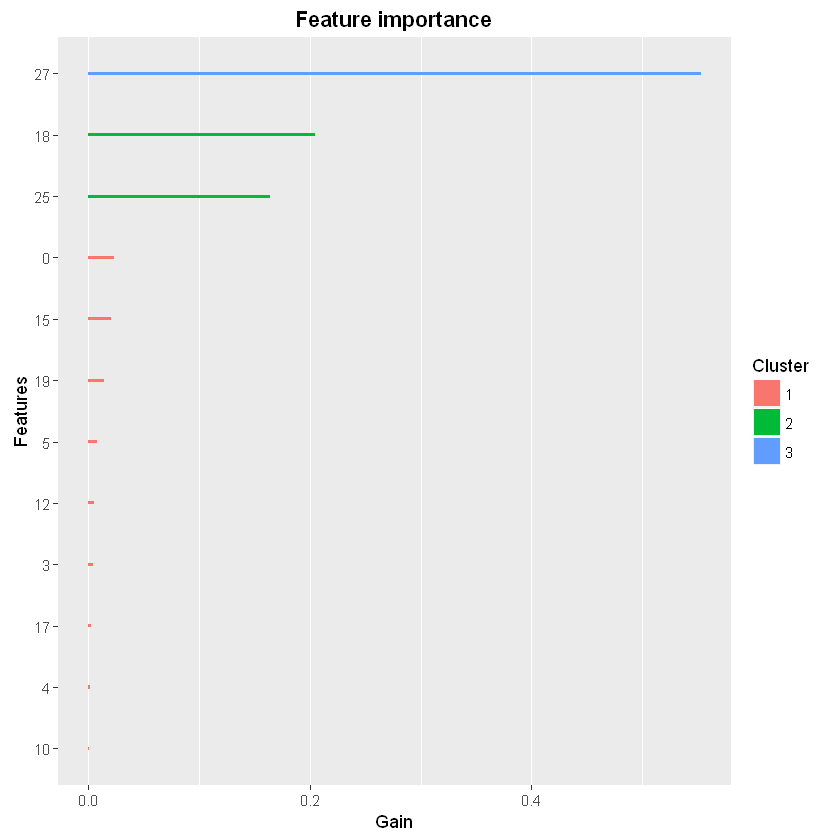

In [13]:
# a mettre les bons lables
importanceRaw <- xgb.importance( model = bst,label=train$label)
xgb.plot.importance(importance_matrix = importanceRaw)

# Train and prediction 

In [14]:
bst = xgboost(param=params, data = as.matrix(train), label = goal, nrounds=num_trees)

[0]	train-auc:0.679147
[1]	train-auc:0.696972
[2]	train-auc:0.707186
[3]	train-auc:0.704921
[4]	train-auc:0.724995


In [21]:
pred = predict(bst,as.matrix(test))
submission=read.csv(paste0(fold_ad,"sample_submission.CSV"))
submission["predictions"] = pred
write.table(submission,file=paste0(fold_ad,"myfirst_submission.CSV"),sep=",",dec=".",quote=FALSE,row.names = FALSE)

# Congratulations you have completed your first xgboost workshop!